# Multilayer perceptron (MLP) / Feedforward network

### - Implement a simple MLP classifier in Tensorflow.
### - Train a neural network using backpropagation

In [1]:
import tensorflow as tf
import numpy as np

/Users/mgh17/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.

### Import and preprocess the data

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [3]:
print(x_train.shape) # training set images
print(y_train.shape) # training set labels
print(x_test.shape)  # test set images
print(y_test.shape)  # test set labels

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [4]:
n_train = x_train.shape[0]
n_test = x_test.shape[0]

print(n_train)
print(n_test)

60000
10000


In [5]:
from matplotlib import pyplot as plt

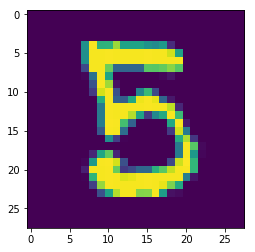

Digit: 5


In [6]:
example = np.random.choice(np.arange(n_train))

image = x_train[example]
label = y_train[example]

plt.imshow(image)
plt.show()

print("Digit: {}".format(label))

### Convert the images to grayscale

In [7]:
def convert_to_grayscale(images):
    return images*255.0

In [8]:
training_set_gs = convert_to_grayscale(x_train)
test_set_gs = convert_to_grayscale(x_test)

In [9]:
print(training_set_gs.shape)
print(test_set_gs.shape)

(60000, 28, 28)
(10000, 28, 28)


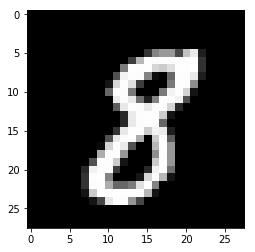

Digit: 8


In [10]:
example = np.random.choice(np.arange(n_train))

image = training_set_gs[example]
label = y_train[example]

if label == 10:
    label = 0

plt.imshow(np.squeeze(image), cmap='gray')
plt.show()

print("Digit: {}".format(label))

Flatten the inputs to feed into an MLP

In [11]:
training_set_flat = training_set_gs.reshape((n_train, -1))
test_set_flat = test_set_gs.reshape((n_test, -1))

print(training_set_flat.shape)
print(test_set_flat.shape)

(60000, 784)
(10000, 784)


### Encode the labels as one-hot vectors

In [12]:
def one_hot(labels):
    
    labels = np.squeeze(labels)
    one_hot_labels = []
    for num in labels:
        one_hot = [0.0] * 10
        one_hot[num] = 1.0
        one_hot_labels.append(one_hot)
    labels = np.array(one_hot_labels).astype(np.float32)
    return labels

In [13]:
training_labels_one_hot = one_hot(y_train)
test_labels_one_hot = one_hot(y_test)

In [14]:
print(training_labels_one_hot.shape)
print(test_labels_one_hot.shape)

(60000, 10)
(10000, 10)


## Build the network

In [15]:
class MNIST_MLP:
    def __init__(self, wd_factor, learning_rate):
        self.wd_factor = wd_factor
        self.learning_rate = learning_rate
        self.train_pointer = 0
        self.test_pointer = 0
        
        self.sess = tf.Session()
        
        self.input = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='input')
        self.ground_truth = tf.placeholder(dtype=tf.float32, shape=[None, 10], name='ground_truth')
        print(self.input)
        
        self._build_graph()
        
    def _build_graph(self):
        weights = []  # for weight decay
        
        with tf.variable_scope('layers'):
            h = tf.layers.dense(self.input, 512, kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.tanh, name='1')
            print(h)
            h = tf.layers.dense(h, 256, kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.tanh, name='2')
            print(h)
            h = tf.layers.dense(h, 64, kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.tanh, name='3')
            print(h)
            self.logits = tf.layers.dense(h, 10, kernel_initializer=tf.glorot_uniform_initializer(), 
                                          activation=tf.identity, name='4')
            print(self.logits)
            self.prediction = tf.nn.softmax(self.logits, name='softmax_prediction')
            
        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, 
                                                                                  labels=self.ground_truth))
            self.loss += self.weight_decay()
            
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss)
            
    def weight_decay(self):
        loss = 0
        for v in tf.global_variables():
            if 'Adam' in v.name:
                continue
            elif 'kernel' in v.name:
                loss += self.wd_factor * tf.nn.l2_loss(v)
        print(loss)
        return loss
    
    def train_minibatch(self, samples, labels, batch_size):
        if self.train_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.train_pointer: self.train_pointer + batch_size]
            labels_minibatch = labels[self.train_pointer: self.train_pointer + batch_size]
            self.train_pointer += batch_size
        else:
            samples_minibatch = samples[self.train_pointer:]
            labels_minibatch = labels[self.train_pointer: self.train_pointer + batch_size]
            self.train_pointer = 0
        return samples_minibatch, labels_minibatch

    def train(self, train_samples, train_labels, train_batch_size, iteration_steps):
        self.sess.run(tf.global_variables_initializer())

        print('Start Training')
        losses = []
        for i in range(iteration_steps):
            samples, labels = self.train_minibatch(train_samples, train_labels, train_batch_size)
            feed_dict = {self.input: samples, self.ground_truth: labels}
            _, loss = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)
            if i % 50 == 0:
                print("Minibatch loss at step {}: {}".format(i, loss))
                losses.append([i, loss])
        return losses
                    
    def test_minibatch(self, samples, labels, batch_size):
        if self.test_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.test_pointer: self.test_pointer + batch_size]
            labels_minibatch = labels[self.test_pointer: self.test_pointer + batch_size]
            self.test_pointer += batch_size
            end_of_epoch = False
        else:
            samples_minibatch = samples[self.test_pointer:]
            labels_minibatch = labels[self.test_pointer: self.test_pointer + batch_size]
            self.test_pointer = 0
            end_of_epoch = True
        return samples_minibatch, labels_minibatch, end_of_epoch
            
    def test(self, test_samples, test_labels, test_batch_size):
        end_of_epoch = False
        losses = []
        while not end_of_epoch:
            samples, labels, end_of_epoch = self.test_minibatch(test_samples, test_labels, test_batch_size)
            feed_dict = {self.input: samples, self.ground_truth: labels}
            losses.append(self.sess.run(self.loss, feed_dict=feed_dict))  
        print("Average test loss: {}".format(np.mean(losses)))

In [16]:
WD_FACTOR = 0.0001
LEARNING_RATE = 0.001
model = MNIST_MLP(WD_FACTOR, LEARNING_RATE)

Tensor("input:0", shape=(?, 784), dtype=float32)
Tensor("layers/1/Tanh:0", shape=(?, 512), dtype=float32)
Tensor("layers/2/Tanh:0", shape=(?, 256), dtype=float32)
Tensor("layers/3/Tanh:0", shape=(?, 64), dtype=float32)
Tensor("layers/4/Identity:0", shape=(?, 10), dtype=float32)
Tensor("loss/add_3:0", shape=(), dtype=float32)


In [17]:
tf.global_variables()

[<tf.Variable 'layers/1/kernel:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'layers/1/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'layers/2/kernel:0' shape=(512, 256) dtype=float32_ref>,
 <tf.Variable 'layers/2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'layers/3/kernel:0' shape=(256, 64) dtype=float32_ref>,
 <tf.Variable 'layers/3/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'layers/4/kernel:0' shape=(64, 10) dtype=float32_ref>,
 <tf.Variable 'layers/4/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'layers/1/kernel/Adam:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'layers/1/kernel/Adam_1:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'layers/1/bias/Adam:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'layers/1/bias/Adam_1:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'layers/2/kernel/Adam:0' shape=(5

### Train the network

In [18]:
TRAIN_BATCH_SIZE = 128
ITERATIONS = 1000

import time
start_time = time.time()

losses = model.train(training_set_flat, training_labels_one_hot, TRAIN_BATCH_SIZE, ITERATIONS)

end_time = time.time()
print("Training time: {}s".format(end_time - start_time))

Start Training
Minibatch loss at step 0: 2.5984957218170166
Minibatch loss at step 50: 0.466300368309021
Minibatch loss at step 100: 0.45643630623817444
Minibatch loss at step 150: 0.3718509078025818
Minibatch loss at step 200: 0.3106904923915863
Minibatch loss at step 250: 0.3991464674472809
Minibatch loss at step 300: 0.46213680505752563
Minibatch loss at step 350: 0.46078383922576904
Minibatch loss at step 400: 0.5111721158027649
Minibatch loss at step 450: 0.43389269709587097
Minibatch loss at step 500: 0.4482395648956299
Minibatch loss at step 550: 0.3429901897907257
Minibatch loss at step 600: 0.3628571629524231
Minibatch loss at step 650: 0.24513459205627441
Minibatch loss at step 700: 0.3379773497581482
Minibatch loss at step 750: 0.4154873490333557
Minibatch loss at step 800: 0.5610483884811401
Minibatch loss at step 850: 0.29817137122154236
Minibatch loss at step 900: 0.2951644957065582
Minibatch loss at step 950: 0.23229411244392395
Training time: 132.89143300056458s


In [19]:
losses = np.array(losses)
print(losses.shape)

(20, 2)


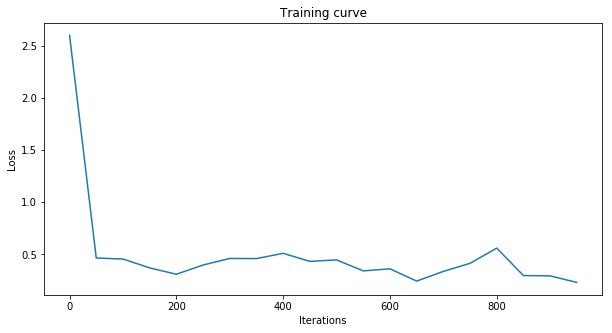

In [20]:
import matplotlib.pyplot as plt

iterations = losses[:, 0]
train_loss = losses[:, 1]
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training curve")
plt.show()

### Test network predictions

In [21]:
TEST_BATCH_SIZE = 128

model.test(test_set_flat, test_labels_one_hot, TEST_BATCH_SIZE)

Average test loss: 0.3384394645690918


Test sample digit: 8


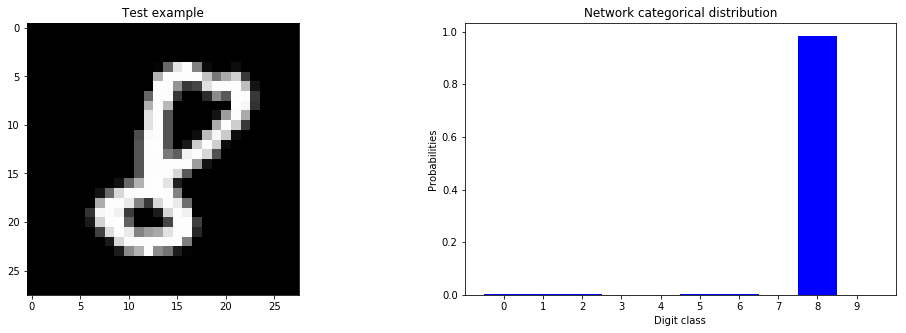

Network prediction probabilities:
[3.9369399e-03 1.2259731e-03 2.8332090e-03 5.9768016e-04 1.4977957e-04
 3.2491700e-03 4.3726675e-03 6.9762027e-06 9.8333955e-01 2.8799821e-04]


In [22]:
example = np.random.choice(np.arange(n_test))

sample = np.expand_dims(test_set_flat[example], axis=0)
label = np.expand_dims(test_labels_one_hot[example], axis=0)

digit = np.where(label[0]==1.0)[0][0]

feed_dict = {model.input: sample, model.ground_truth: label}
prediction = model.sess.run(model.prediction, feed_dict=feed_dict)[0]

image = np.reshape(sample, (28, 28))

print("Test sample digit: {}".format(digit))
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Test example")

classes = np.arange(10)
width = 1.0

#fig, ax = plt.subplots()
ax[1].bar(classes, prediction, width, color='Blue')
ax[1].set_ylabel('Probabilities')
ax[1].set_title('Network categorical distribution')
ax[1].set_xticks(classes)
ax[1].set_xticklabels(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))
ax[1].set_xlabel('Digit class')

plt.show()

print("Network prediction probabilities:")
print(prediction)

In [23]:
model.sess.close()